## Install Dependencies

In [1]:
# pip installs

!pip install -q datasets requests torch peft bitsandbytes transformers trl accelerate sentencepiece wandb matplotlib

## Import Libraries

In [2]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
import wandb
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from datetime import datetime
import matplotlib.pyplot as plt

## Setting Constants and Hyperparameters

In [3]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
HF_USER = "HazemAshraf"

# Data
DATASET_NAME = "ed-donner/pricer-data"
MAX_SEQUENCE_LENGTH = 182

# Run name for saving the model in the hub

RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training

EPOCHS = 1
BATCH_SIZE = 4
GRADIENT_ACCUMULATION_STEPS = 1
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

# Admin config - note that SAVE_STEPS is how often it will upload to the hub

STEPS = 50
SAVE_STEPS = 500
LOG_TO_WANDB = True

%matplotlib inline

In [4]:
HUB_MODEL_NAME

'HazemAshraf/pricer-2025-03-17_23.10.34'

## Log in to HuggingFace and Weights & Biases

In [5]:
# Log in to HuggingFace

hf_token = userdata.get('hf_token')
login(hf_token, add_to_git_credential=True)

In [6]:
# Log in to Weights & Biases
wandb_api_key = userdata.get('wandb_api_key')
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hazem-ashraf (hazem-ashraf-fau-erlangen-n-rnberg) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Load the Dataset

In [7]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# if you wish to reduce the training dataset to 2,000 points instead, then uncomment this line:
train = train.select(range(2000))

In [9]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

## Configure Quantization Settings

In [10]:
# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

## Load the Tokenizer and Model

In [11]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5591.5 MB


# Data Collator

It's important that we ensure during Training that we are not trying to train the model to predict the description of products; only their price.

We need to tell the trainer that everything up to "Price is $" is there to give context to the model to predict the next token, but does not need to be learned.

The trainer needs to teach the model to predict the token(s) after "Price is $".

There is a complicated way to do this by setting Masks, but luckily HuggingFace provides a super simple helper class to take care of this for us.

In [12]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## Set up the configuration for Training

We need to create 2 objects:

A LoraConfig object with our hyperparameters for LoRA

An SFTConfig with our overall Training parameters

In [13]:
# First, specify the configuration parameters for LoRA

lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    tokenizer=tokenizer,
    args=train_parameters,
    data_collator=collator
)

<ipython-input-13-159c93dc3bd4>:48: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  fine_tuning = SFTTrainer(


Converting train dataset to ChatML:   0%|          | 0/2000 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Fine-tuning

In [14]:
# Fine-tune
fine_tuning.train()

# Push our fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

Step,Training Loss
50,2.052600
100,1.983100
150,1.901100
200,1.849400
250,1.912700
300,1.947400
350,1.868500
400,1.854700
450,1.880700
500,1.869200


wandb: Adding directory to artifact (./pricer-2025-03-17_23.10.34/checkpoint-500)... Done. 6.5s


README.md:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


Saved to the hub: pricer-2025-03-17_23.10.34


In [15]:
if LOG_TO_WANDB:
  wandb.finish()

train/epoch,▁▂▃▃▄▅▆▆▇██
train/global_step,▁▂▃▃▄▅▆▆▇██
train/grad_norm,▅▁▁█▅▁▂▃▆▄
train/learning_rate,██▇▆▅▄▃▂▁▁
train/loss,█▆▃▁▃▄▂▁▂▂
train/mean_token_accuracy,▁▆▇█▆▇███▇
total_flos,1.6068144750723072e+16
train/epoch,1
train/global_step,500
train/grad_norm,3.82278
train/learning_rate,0


## Restart your session!
## Predict Product Prices

In [1]:
import os
import re
import math
from tqdm import tqdm
from google.colab import userdata
from huggingface_hub import login
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset, Dataset, DatasetDict
from datetime import datetime
from peft import PeftModel
import matplotlib.pyplot as plt

In [2]:
# Constants

BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
HF_USER = "HazemAshraf" # your HF name here! Or use mine if you just want to reproduce my results.

# The run itself

RUN_NAME = "2025-03-17_23.10.34"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Data

DATASET_NAME = "ed-donner/pricer-data"

# Hyperparameters for QLoRA

QUANT_4_BIT = True

%matplotlib inline

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [3]:
# Log in to HuggingFace

hf_token = userdata.get('hf_token')
login(hf_token, add_to_git_credential=True)

dataset = load_dataset(DATASET_NAME)
train = dataset['train']
test = dataset['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
test[0]

{'text': "How much does this cost to the nearest dollar?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K\n\nPrice is $",
 'price': 374.41}

## Load the Tokenizer and Model

In [5]:
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [6]:
# Load the Tokenizer and the Model

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map="auto",
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

# Load the fine-tuned model with PEFT
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)


print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

adapter_config.json:   0%|          | 0.00/752 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

Memory footprint: 5700.6 MB


In [7]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [8]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [9]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [10]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [11]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $273.00 Truth: $374.41 Error: $101.41 SLE: 0.10 Item: OEM AC Compressor w/...
2: Guess: $111.94 Truth: $225.11 Error: $113.17 SLE: 0.48 Item: Motorcraft YB3125 Fa...
3: Guess: $59.66 Truth: $61.68 Error: $2.02 SLE: 0.00 Item: Dorman Front Washer ...
4: Guess: $383.25 Truth: $599.99 Error: $216.74 SLE: 0.20 Item: HP Premium HD Plus T...
5: Guess: $37.97 Truth: $16.99 Error: $20.98 SLE: 0.60 Item: Super Switch Pickup ...
6: Guess: $13.23 Truth: $31.99 Error: $18.76 SLE: 0.71 Item: Horror Bookmarks, Re...
7: Guess: $159.50 Truth: $101.79 Error: $57.71 SLE: 0.20 Item: SK6241 - Stinger 4 G...
8: Guess: $283.50 Truth: $289.00 Error: $5.50 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $666.50 Truth: $635.86 Error: $30.64 SLE: 0.00 Item: Randall G3 Plus Comb...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.04 Item: HOLDWILL 6 Pack LED ...
11: Guess: $253.75 Truth: $254.21 Error: $0.46 SLE: 0.00 Item: Viking Horns 3 Gallo...
12: Guess: $265.00 Truth: $412.99 Error: $147.99 

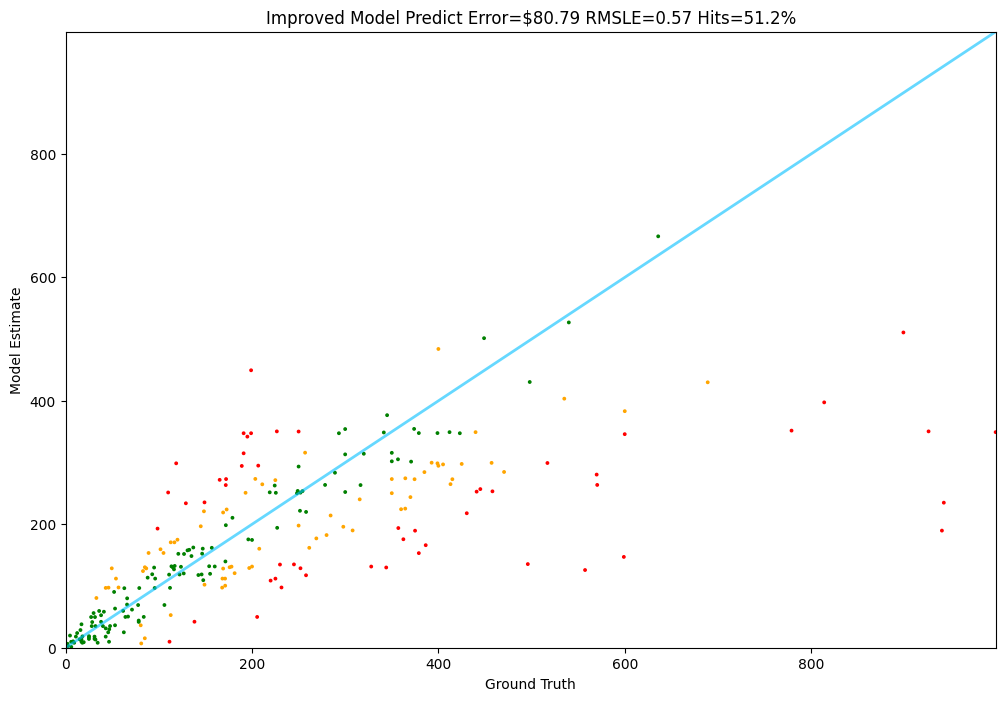

In [12]:
Tester.test(improved_model_predict, test)